Peter Haas, Kiel University, 16 April 2021

Script to calculate regionalization maps based on the AF2019 seismic tomography model for the African continent of Celli et al 2020. For more information see here:
https://nlscelli.wixsite.com/ncseismology/models
The underlying algorithm is kmeans, which is implemented "from scratch" (I don't make use of the scikit.learn package in this code).

This version is preliminary and comments will be updated soon. When using, please cite the corresponding paper of Haas et al. 2021, which is submitted for Frontiers in Earth Science:
Haas, P., J. Ebbing, N. Celli and P. Rey - Two-step gravity inversion reveals variable architecture of African cratons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
from matplotlib.colors import ListedColormap
import os
# Here you have to include the path where the "proj4" is located (essential to use the Basemap package)
os.environ['PROJ_LIB'] = r'C:\Users\Peter\Anaconda3\pkgs\proj4-5.2.0-h6538335_1006\Library\share'
from mpl_toolkits.basemap import Basemap
import itertools
import time

In this example, I have sampled tomography model to 1 degree resolution and interpolated each point in 10 km steps in depth.
Load tomography and cut certain depth extension. File needs to have 4 columns: Longitude, Latitude, Depth, Vs.

In [2]:
upper_bound=30
lower_bound=350
depth_inc=10

Cut the tomography to the select depth extension

In [3]:
tomo_vs=np.loadtxt("AF2019_prep_regionalization_1degree.txt")
tomo_vs=tomo_vs[~(tomo_vs[:,2]<upper_bound)]
tomo_vs=tomo_vs[~(tomo_vs[:,2]>lower_bound)]
tomo_vs=tomo_vs[np.lexsort((tomo_vs[:,0],tomo_vs[:,1]))]      

Load reference regionalization 

In [4]:
clusters_ref=np.loadtxt("Reg_AF2019_n6.txt")
clusters_ref=clusters_ref[np.lexsort((clusters_ref[:,0],clusters_ref[:,1]))]
print(clusters_ref)

[[-25. -40.   5.]
 [-24. -40.   5.]
 [-23. -40.   5.]
 ...
 [ 61.  40.   2.]
 [ 62.  40.   2.]
 [ 63.  40.   2.]]


Prepare some coordinates

In [5]:
dx=1.0
dy=1.0
a=np.arange(np.amin(tomo_vs[:,0]),np.amax(tomo_vs[:,0])+dx,dx)
b=np.arange(np.amin(tomo_vs[:,1]),np.amax(tomo_vs[:,1])+dy,dy)
c=np.arange(np.amin(tomo_vs[:,2]),np.amax(tomo_vs[:,2])+0.5,depth_inc)
longr,latgr=np.meshgrid(a,b)
lon=longr.flatten()
lat=latgr.flatten()

In [6]:
tomo_vs_prep=np.reshape(tomo_vs[:,3],(len(a)*len(b),len(c)))

Define the maximum number of clusters for the regionalization.

In [7]:
cluster_numbers=12

Define kmeans from scratch, based on an implementation from Georgios Drakos, which I adjusted by a few lines.

https://gdcoder.com/implementation-of-k-means-from-scratch-in-python-9-lines/


In [8]:
def kmeans(X,cluster_numbers,max_iterations,n_init):
    '''
    X: multidimensional data
    cluster_numbers: number of clusters
    max_iterations: number of repetitions before clusters are established
    n_init: number of different centroids per iteration
    
    Steps:
    1. Convert data to numpy aray
    2. Pick indices of k random point without replacement
    3. Find class (P) of each data point using euclidean distance
    4. Stop when max_iteration are reached of P matrix doesn't change
    
    Return:
    P_total = np.array: containg class of each data point
    wcss = np.array: Within Cluster Sum of Squares for each iteration
    '''

    P_total=np.zeros((len(X),cluster_numbers+1))
    wcss_total=[]
    for k in range(1,cluster_numbers+1):
        print(k)
        eucl_global_save_old = 10**11
        P_save = 0
        for h in range(n_init):
            idx = np.random.choice(len(X), k, replace=False)
            centroids = X[idx, :]
            P = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
            eucl_sum_old= 10**11
            for i in range(max_iterations):
                centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
                tmp = np.argmin(distance.cdist(X, centroids, 'euclidean'),axis=1)
                eucl_sum = np.sum(np.amin(distance.cdist(X, centroids, 'euclidean'),axis=1))
                if eucl_sum < eucl_sum_old:
                    eucl_sum_save = np.copy(eucl_sum)
                eucl_sum_old = np.copy(eucl_sum)

                if np.array_equal(P,tmp):
                    eucl_global_save=np.copy(eucl_sum_save)

                    if eucl_global_save < eucl_global_save_old:
                        P_save = tmp
                        eucl_global_save_old = np.copy(eucl_global_save)
                        wcss = np.sum(np.amin(distance.cdist(X, centroids, 'sqeuclidean'),axis=1))
                        break
                    else:
                        break
                P = tmp
        P_total[:,k] = P_save
        wcss_total.append(wcss)
    return P_total,wcss_total

The kmeans will now loop over all cluster numbers. Try to vary max_iteration number and n_init number. (Default max_iterations=400, n_init=70)

In [9]:
P,wcss = kmeans(tomo_vs_prep,cluster_numbers=cluster_numbers,max_iterations=400,n_init=70)

1
2
3
4
5
6
7
8
9
10
11
12


Plot Within Cluster Sum of Squares for Euclidean distance

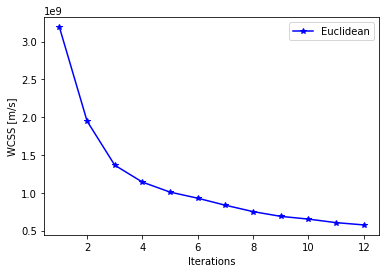

In [11]:
plt.plot(range(1,cluster_numbers+1),wcss,'b*-',label='Euclidean')
plt.xlabel('Iterations')
plt.ylabel('WCSS [m/s]')
plt.legend()
plt.show()

Set up basemap

In [12]:
area = (lon.min(), lon.max(), lat.min(), lat.max())

In [13]:
bm = Basemap(projection='cyl', 
             llcrnrlon=area[0], urcrnrlon=area[1], 
             llcrnrlat=area[2], urcrnrlat=area[3],
             lon_0=0.5*(area[0] + area[1]), lat_0=0.5*(area[3] + area[2]), 
             resolution='l')

Define a colormap. The commented lines represent the colour map of the SL2013sv regionalization 

In [14]:
rgb_values=np.array(([61.0,204.0,75.0],[0.0,64.0,255.0],[167.0,186.0,209.0],
                     [204.0,3.0,0.0],[255.0,187.0,51.0],[102.0,51.0,0.0],
                     [174.0,234.0,180.0],[32.0,121.0,41.0]))/255

cmp_regionalization = ListedColormap(rgb_values[:,0:3])

Define a plot function

In [15]:
def plot_data(lon, lat, data, area, vmin, vmax, cblabel='km', levels=60,ranges=True):
    plt.rcParams.update({'font.size': 16})
    x=np.arange(area[0],area[1]+1,dx)
    y=np.arange(area[2],area[3]+1,dy)
    X, Y = np.meshgrid(x, y)
    XX,YY=bm(X,Y)
    points=np.vstack((lon,lat)).T
    grid_z0 = griddata(points, data, (X, Y), method='nearest')
    fig = plt.figure(figsize=(14, 7))
    bm.pcolor(XX, YY, grid_z0, cmap=cmp_regionalization, vmin=vmin, vmax=vmax)
    bm.drawmeridians(np.arange(-180, 180, 20), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-80, 80, 20), labels=[1, 0, 0, 0], linewidth=0.2)
    bm.drawcoastlines(color="#333333")
    m = plt.cm.ScalarMappable(cmap=cmp_regionalization)
    m.set_array(data)
    m.set_clim(vmin, vmax)
    plt.tight_layout(pad=0)

Import permutation function to loop over all possible combinations for a certain cluster number. This is necessary, as the kmeans algorithm provides sorts the cluster numbers differently, depending on where the initial seeds have been placed.

Take care with the selection of the cluster numbers!

The number of variations increases factorial with cluster number. 
Example: For n=7 clusters, the total number variations is ${8!}=40320$.
This corresponds to full memory of 16 GB in use when calculating the "rename"-matrix. I recommend to limit the numbers to maximum 7.

In [16]:
def rename(A):
    assert A.dtype==int
    n = A.max()+1 
    elements = np.arange(n,dtype=int)
    permutations = np.array(list(itertools.permutations(elements)))
    A_renamed = np.zeros((permutations.shape[0],A.size))
    for i in range(len(permutations)):
        for j in range(len(elements)):
            A_renamed[i,A==j] = permutations[i][j]
    return A_renamed

Loop over all possible combinations per cluster number. The difference is calculated against the reference regionalization. See comment above for selection of maximum number of clusters! 

In [17]:
cluster_numbers=7
Q=np.zeros((clusters_ref.shape[0],cluster_numbers))
for i in range(1,cluster_numbers+1):
    clusters=rename(P[:,i].astype(int))
    clusters=clusters.T+1
    clusters_copy=clusters[~(clusters_ref[:,2]>int(i))]
    clusters_ref_cut=clusters_ref[~(clusters_ref[:,2]>int(i))]
    diff=np.abs(clusters_copy.T-clusters_ref_cut[:,2])
    diff_pc=(len(clusters_copy)-np.count_nonzero(diff,axis=1))/len(clusters_copy)
    print(np.amax(diff_pc))
    Q[:,i-1]=clusters[:,np.argmax(diff_pc)]

1.0
0.5871886120996441
0.6653349723417332
0.7368797709923665
0.829064296915839
0.994173949230129
0.8621167984463864


You'll see that for n=6 clusters the result agrees to 99.9% with the reference regionalization. 

Finally plot the regionalization. 

IndexError: index 7 is out of bounds for axis 1 with size 7

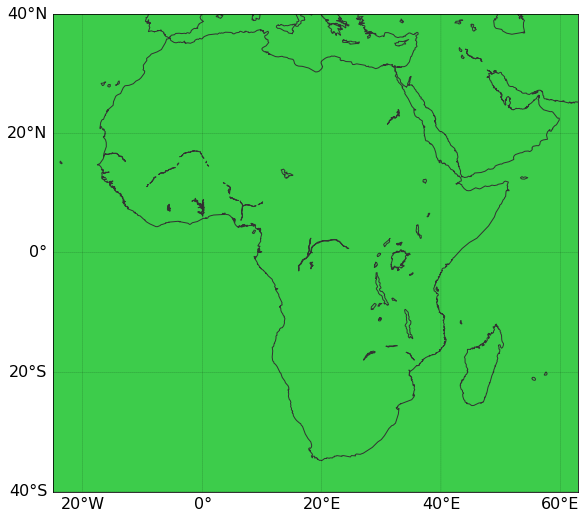

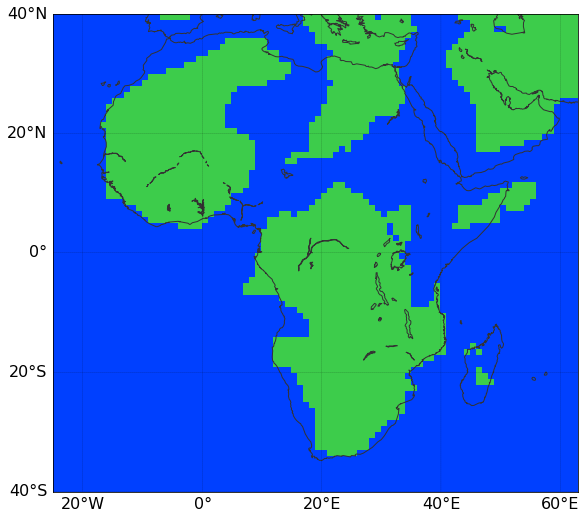

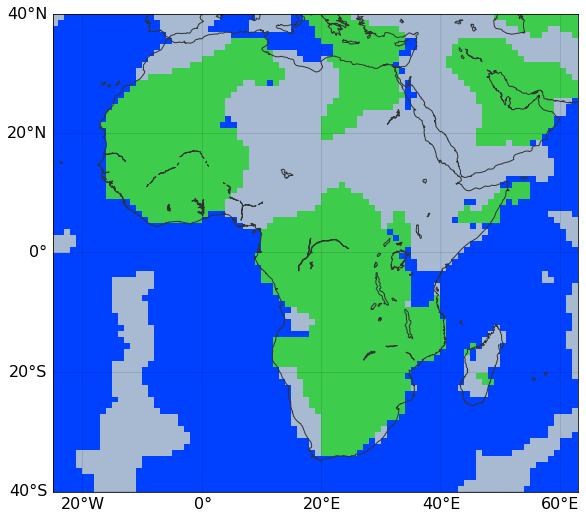

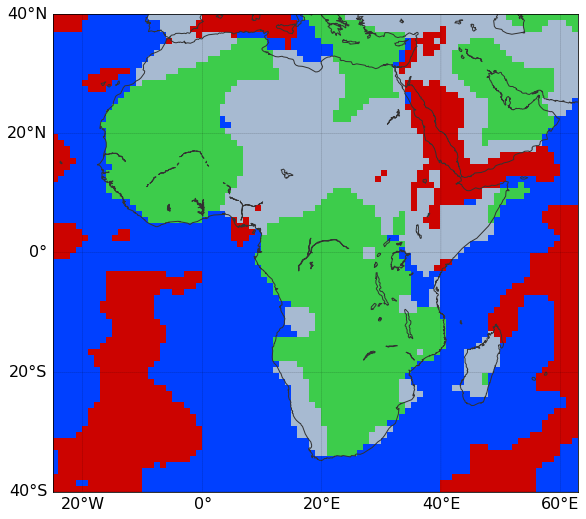

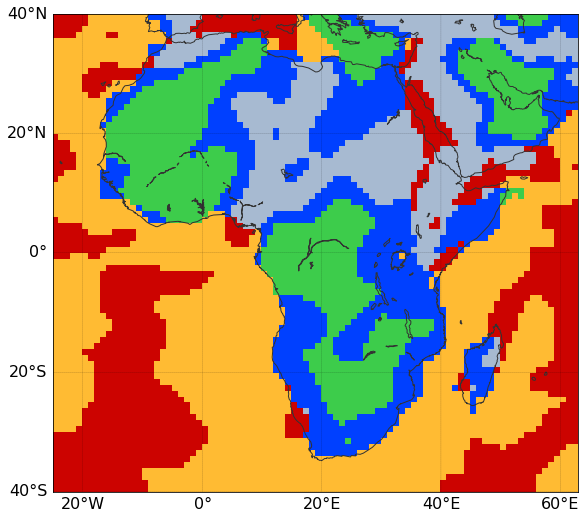

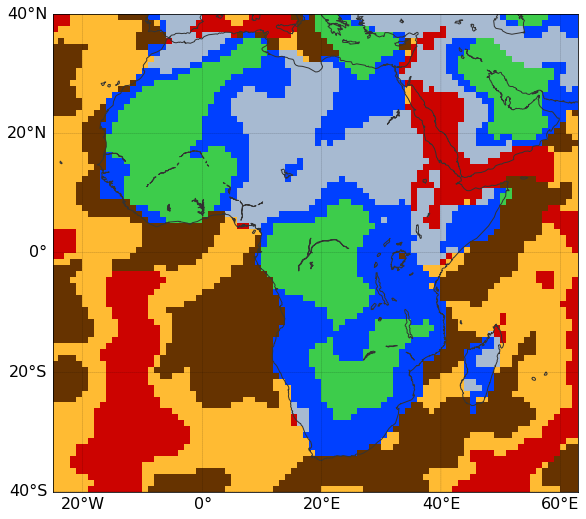

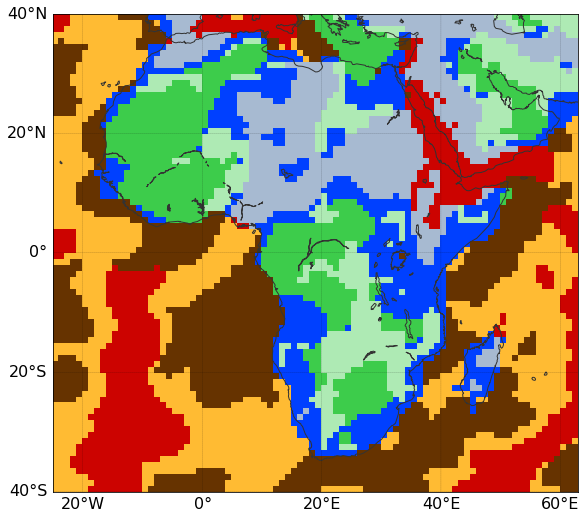

In [19]:
for i in range(cluster_numbers+1):
    plot_data(lon,lat,Q[:,i],area, 1,rgb_values.shape[0])